# Customer loans in Finance

Here we test the class by first running an instance of the class under the variable 'test' and the input of our locally stored credentials.yaml file
Then we can run our methods from the test instance

In [1]:
#Here we import only the neccessary modules

import yaml
import pandas as pd
from sqlalchemy import create_engine, inspect

'''
The following is a class to connect to an RDS database and extract a loan payments dataframe and save it into a csv file
'''
class DataTransform:

    def __init__(self, loan_payments_table):

        self.loan_payments_table = loan_payments_table

    def check_id_unique(self):
        
        num_unique_ids = loan_payments_table['id'].nunique()

        row_count = len(loan_payments_table)

        if num_unique_ids == row_count:
            print("All id's are unique")
        else:
            print("Not all of the id's are unique")

        return

    def str_to_int(self):

        loan_payments_table['term'].str.replace('36 months', '36').astype(float)

        return

class RDSDatabaseConnector(DataTransform):

    '''
    Here we initialise the class with the only input needed is the 'credentials', which includes the details needed to access the RDS database
    
    '''

    def __init__(self, creds: dict):
        self.creds = creds

    '''
    The db_engine method is there to open the credentials file that is input by the user
    It extracts the various credentials and uses it to open the file; saving the out put into the engine variable
    The engine variable can be thought of as a key to access the database
    '''

    def db_engine(self):

        with open(self.creds, 'r') as file: #opening the yaml file input and creating an instance of the class in the variable self.creds_dict variable
            self.creds_dict = yaml.safe_load(file)
    
        DATABASE_TYPE = 'postgresql'
        DBAPI = 'psycopg2'
        ENDPOINT = self.creds_dict['RDS_HOST']
        USER = self.creds_dict['RDS_USER']
        PASSWORD = self.creds_dict['RDS_PASSWORD']
        PORT = 5432
        DATABASE = self.creds_dict['RDS_DATABASE']
        engine = create_engine(f"{DATABASE_TYPE}+{DBAPI}://{USER}:{PASSWORD}@{ENDPOINT}:{PORT}/{DATABASE}")
        return engine
    
    '''
    The get_table_names does what it says on the tin, it gets the table names
    We use the built in inspect function from the sqlalchemy library to inspect the whole database
    Then the get_table_names() function returns a list of table names
    '''
    
    def get_table_names(self, engine):

        inspector = inspect(engine)

        return inspector.get_table_names()
    
    '''
    'loan payments' is the table we're looking for
    We use the engine along with the built in read_sql() function from the pandas library to assign the table to the variable 'loan_payments_table'
    '''
    
    def extract_data(self, engine):

        loan_payments_table = pd.read_sql('loan_payments', engine)

        return loan_payments_table
    
    ''''
    Now we can save that table to a csv file using the save_data() method
    '''
    
    def save_data(self, loan_payments_table):

        loan_payments_table.to_csv('df.csv')

        return
    
    '''
    To have an idea about what the data looks like,
    the show_data() method shows a snippet of the table with all the columns and a small number of rows
    '''
    
    def show_data(self, loan_payments_table):

        data_frame = pd.DataFrame(data=loan_payments_table)

        pd.set_option('display.max_rows', 30)

        pd.set_option('display.max_columns', None)

        print(data_frame)
        
        return
    
        
'''
Here we test the class by first running an instance of the class under the variable 'test' and the input of our locally stored credentials.yaml file
Then we can run our methods from the test instance
'''

test = RDSDatabaseConnector('credentials.yaml')

engine= test.db_engine() #get the key to the database using the credentials

table_names = test.get_table_names(engine) #use the key to get the table names

print(table_names) #view the table names

loan_payments_table = test.extract_data(engine) #use the key to access the loan payments table

test.show_data(loan_payments_table) # show a snippit of the data

# test = DataTransform(loan_payments_table)

# check_id = test.check_id_unique()

#term_months_into_years = test.str_to_int()

test.save_data(loan_payments_table) #save the loan payments table to the csv file

['loan_payments']
             id  member_id  loan_amount  funded_amount  funded_amount_inv  \
0      38676116   41461848         8000         8000.0             8000.0   
1      38656203   41440010        13200        13200.0            13200.0   
2      38656154   41439961        16000        16000.0            16000.0   
3      38656128   41439934        15000        15000.0            15000.0   
4      38656121   41439927        15000        15000.0            15000.0   
...         ...        ...          ...            ...                ...   
54226     76597      76583         5000         5000.0             1775.0   
54227    142608      74724         5000         5000.0             2350.0   
54228    117045      70978         3500         3500.0             2225.0   
54229     88854      70699         5000         5000.0              225.0   
54230     72323      70694         5000         5000.0              350.0   

            term  int_rate  instalment grade sub_grade em

In [ ]:
class DataFrameInfo:

    def __init__(self, loan_payments_table):

        self.loan_payments_table = loan_payments_table

    def column_data_types(self):
        
        return loan_payments_table.dtypes
    
    def get_median(self):

        return loan_payments_table.median(numeric_only=True)

    def get_standard_deviation(self):

        return loan_payments_table.std(numeric_only=True)

    def get_mean(self):

        return loan_payments_table.mean(numeric_only=True)
    
    def count_categorical_values(self):

        loan_payments_column_names = list(loan_payments_table.columns)

        for column_name in loan_payments_column_names:

            if loan_payments_table[column_name].dtype == object:

                print(loan_payments_table[column_name].value_counts())
            
            else:

                pass

        return
    
    def get_shape(self):

        return loan_payments_table.shape
    
    def null_values(self):
        print("Percentage of null values:")
        print(loan_payments_table.isnull().sum() * 100 / len(loan_payments_table))

        print("Number of null values:")
        return loan_payments_table.isna().sum()


test_1 = DataFrameInfo(loan_payments_table)

test_1.column_data_types() #working

# test_1.get_median()

# test_1.get_standard_deviation()

# test_1.get_mean()

funded_amount_mean = test_1.get_mean()

test_1.count_categorical_values()

# test_1.get_shape()

test_1.null_values()

term
36 months    35845
60 months    13614
Name: count, dtype: int64
grade
B    16369
C    13600
A     9818
D     8157
E     4072
F     1694
G      521
Name: count, dtype: int64
sub_grade
B3    3641
B4    3542
B2    3241
C1    3018
B5    3016
      ... 
G1     156
G2     133
G3      87
G4      74
G5      71
Name: count, Length: 35, dtype: int64
employment_length
10+ years    15907
2 years       5066
< 1 year      5034
3 years       4589
5 years       3836
1 year        3708
4 years       3482
6 years       3059
7 years       2964
8 years       2537
9 years       1931
Name: count, dtype: int64
home_ownership
MORTGAGE    26923
RENT        22493
OWN          4750
OTHER          63
NONE            2
Name: count, dtype: int64
verification_status
Verified           20782
Not Verified       17565
Source Verified    15884
Name: count, dtype: int64
issue_date
Dec-2019    7356
Nov-2019    7026
Oct-2019    6738
Sep-2019    6080
Jan-2021    4224
            ... 
Aug-2013      35
Sep-2014      34
S

id                                 0
member_id                          0
loan_amount                        0
funded_amount                   3007
funded_amount_inv                  0
                               ...  
last_credit_pull_date              7
collections_12_mths_ex_med        51
mths_since_last_major_derog    46732
policy_code                        0
application_type                   0
Length: 43, dtype: int64

                                   id  loan_amount  funded_amount  int_rate  \
id                           1.000000     0.133721       0.144593  0.059191   
loan_amount                  0.133721     1.000000       0.993946  0.214254   
funded_amount                0.144593     0.993946       1.000000  0.217039   
int_rate                     0.059191     0.214254       0.217039  1.000000   
instalment                   0.137922     0.947109       0.955657  0.201341   
annual_inc                   0.042435     0.369098       0.365590  0.003225   
dti                          0.200950     0.093865       0.097991  0.180900   
delinq_2yrs                  0.063277     0.014964       0.017549  0.112172   
inq_last_6mths               0.093655     0.037443       0.038224  0.173122   
mths_since_last_delinq       0.008736     0.035496       0.037911  0.054007   
mths_since_last_record       0.040149     0.066335       0.064872  0.082883   
open_accounts                0.152285     0.213563  

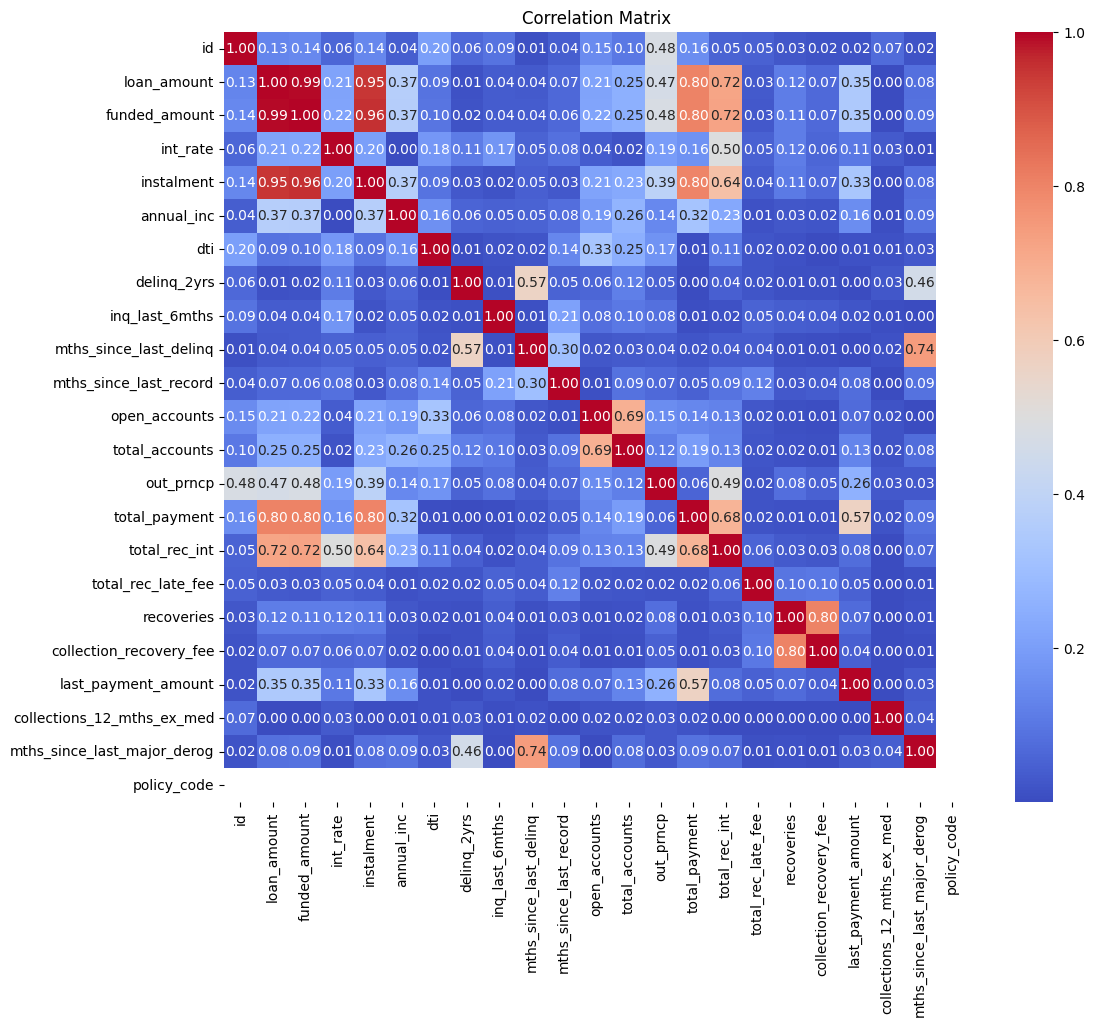

{'loan_amount', 'instalment', 'funded_amount'}
{('funded_amount', 'loan_amount'), ('funded_amount', 'instalment'), ('instalment', 'loan_amount'), ('instalment', 'funded_amount'), ('loan_amount', 'funded_amount'), ('loan_amount', 'instalment')}


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import zscore


class Plotter:

    def __init__(self, loan_payments_table):

        self.loan_payments_table = loan_payments_table
    
    def plot_null(self):

        loan_payments_table.isna().sum().plot(kind='bar')

        return
    
    def plot_skew(self):

        loan_payments_table.skew(numeric_only=True).plot(kind='bar')

    def plot_outliers(self):

        loan_payments_table.plot(kind='box', figsize=(16,12))



class DataFrameTransform(RDSDatabaseConnector, Plotter):

    def __init__(self, loan_payments_table):

        self.loan_payments_table = loan_payments_table

    
    def null_values(self):

        print("Percentage of null values:")

        print(loan_payments_table.isnull().sum() * 100 / len(loan_payments_table))

        print("Number of null values:")

        print(loan_payments_table.isna().sum())

        pd.options.display.max_rows = 4000

        return
    
    def drop_columns(self):

        loan_payments_table.drop(columns='mths_since_last_delinq', inplace=True)

        loan_payments_table.drop(columns='mths_since_last_record', inplace=True)

        loan_payments_table.drop(columns='funded_amount', inplace=True)

        loan_payments_table.drop(columns='mths_since_last_major_derog', inplace=True)

        loan_payments_table.drop(columns='next_payment_date', inplace=True)

        return loan_payments_table

    def impute_columns(self):

        int_rate_mean = loan_payments_table['int_rate'].mean(numeric_only=True)

        loan_payments_table['int_rate'].fillna(int_rate_mean, inplace=True)

        term_mean = loan_payments_table['int_rate'].mean(numeric_only=True)

        loan_payments_table['term'].fillna(term_mean, inplace=True)

        employment_length_mean = loan_payments_table['int_rate'].mean(numeric_only=True)

        loan_payments_table['employment_length'].fillna(employment_length_mean, inplace=True)

        collections_12_mths_ex_med_mean = loan_payments_table['collections_12_mths_ex_med'].mean(numeric_only=True)

        loan_payments_table['collections_12_mths_ex_med'].fillna(collections_12_mths_ex_med_mean, inplace=True)

        last_payment_date_mode = loan_payments_table['last_payment_date'].mode()[0]

        loan_payments_table['last_payment_date'].fillna(last_payment_date_mode, inplace=True)

        last_credit_pull_date_mode = loan_payments_table['last_credit_pull_date'].mode()[0]

        loan_payments_table['last_credit_pull_date'].fillna(last_credit_pull_date_mode, inplace=True)

        return
    
    def skewness(self):

        print(loan_payments_table.skew(numeric_only=True))

        return
    
    def reduce_skew(self):

        skewed_columns = ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_accounts', 'out_prncp', 'out_prncp_inv', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_payment_amount', 'collections_12_mths_ex_med']

        print(skewed_columns)

        for column in skewed_columns:

            loan_payments_table[column] = loan_payments_table[column].map(lambda i: np.log(i) if i > 0 else 0)

            return

        for column in skewed_columns:
    
            yeojohnson_column, _ = stats.yeojohnson(loan_payments_table[column])

            loan_payments_table[column] = yeojohnson_column 

            return    #works to get most of the skewed

        return

    def remove_outliers(self, column):
        
        z_scores = zscore(loan_payments_table[column].astype(int))

        loan_payments_table.loc[abs(z_scores) > 3, column] = loan_payments_table[column].mean()

        print(column)

        return
    
    def overly_corr_col(self):

        # Create correlation matrix

        corr_matrix = loan_payments_table.corr(numeric_only=True).abs()

        print(corr_matrix)

        #Visualize correlation matrix

        plt.figure(figsize=(12, 10))

        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

        plt.title('Correlation Matrix')

        plt.show()

        # Identify highly correlated columns

        correlated_columns = set()

        correlated_columns_unique = set()

        for i in range(len(corr_matrix.columns)):

            for j in range(len(corr_matrix.columns)):

                if abs(corr_matrix.iloc[i,j]) >= 0.9:

                    col_name_1 = corr_matrix.columns[i]

                    col_name_2 = corr_matrix.columns[j]
                    
                    if col_name_1 != col_name_2:

                        correlated_columns.add((col_name_1, col_name_2))

                        correlated_columns_unique.add(col_name_1)

                        correlated_columns_unique.add(col_name_2)

        print(correlated_columns_unique)

        print(correlated_columns)

        return
    
    def drop_overly_corr(self, overly_correlated_columns):
        
        print(overly_correlated_columns)

        for column in overly_correlated_columns:

           self.loan_payments_table.drop(columns=[column], inplace=True)

        return



    
test = DataFrameTransform(loan_payments_table)

# test.null_values()

# loan_payments_table = test.drop_columns()

# test.impute_columns()

# test.plot_null()

#test.reduce_skew()

# test.skewness()

# test.plot_skew()

#test.transform_outliers()

# column = 'annual_inc'

# test.remove_outliers(column)

# test.plot_outliers()

test.overly_corr_col()

overly_correlated_columns = ['funded amount','out_prncp_inv', 'total_payment_inv', 'total_rec_prncp', 'member_id', 'funded_amount_inv']

#test.drop_overly_corr(overly_correlated_columns)

test.save_data(loan_payments_table) #save the loan payments table to the csv file